<a href="https://colab.research.google.com/github/Niranjen99/Deep_learning_Assessment_2/blob/main/ResNet_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

Connecting to Roboflow and downloading the dataset "Thermal Dogs and People." Adjust the API key for authorized access.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="********")
project = rf.workspace("joseph-nelson").project("thermal-dogs-and-people")
version = project.version(6)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Thermal-Dogs-and-People-6 in yolov5pytorch:: 100%|██████████| 418/418 [00:00<00:00, 5181.12it/s]


Printing the downloaded dataset's path and directory contents to verify proper downloading.

In [ ]:
import os

# Print the location where the dataset was downloaded
print("Dataset downloaded to:", dataset.location)

# List the contents of the dataset directory
print("Contents:", os.listdir(dataset.location))



Dataset downloaded to: /content/Thermal-Dogs-and-People-6
Contents: ['valid', 'data.yaml', 'README.dataset.txt', 'test', 'README.roboflow.txt', 'train']


Creating the directory structure for training, validation, and test sets, with separate folders for each class ('dog,' 'person,' and 'mixed') for easy image management and compatibility with ImageFolder.



In [ ]:


# Define the base directory for the new ImageFolder dataset
imagefolder_dir = '/content/ThermalDogsAndPeople_ImageFolder'

# Create the folder structure for ImageFolder, including the "mixed" class
os.makedirs(os.path.join(imagefolder_dir, 'train/dog'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'train/person'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'train/mixed'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'valid/dog'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'valid/person'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'valid/mixed'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'test/dog'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'test/person'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'test/mixed'), exist_ok=True)

print("Folder structure created with the 'mixed' class.")


Folder structure created with the 'mixed' class.


This section reorganizes the dataset by moving images to the respective class folders. Images with both 'dog' and 'person' labels go into the 'mixed' folder.

In [ ]:
import shutil

# Function to move images to the respective class folders, with "mixed" images placed only in the "mixed" folder
def move_images_to_class_folders(base_dir, output_base_dir, phase):
    images_dir = os.path.join(base_dir, phase, 'images')
    labels_dir = os.path.join(base_dir, phase, 'labels')

    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()

        # Identify the class labels in the annotation file
        classes_in_file = set([int(line.split()[0]) for line in lines])  # YOLO format uses class index

        # Skip images that have no class annotations
        if not classes_in_file:
            print(f"Skipping {label_file}: no class annotations found.")
            continue

        image_name = label_file.replace('.txt', '.jpg')
        image_path = os.path.join(images_dir, image_name)

        # Determine the target folder
        if len(classes_in_file) > 1:  # If there are multiple classes, use "mixed" only
            target_folder = os.path.join(output_base_dir, phase, 'mixed')
        else:  # Otherwise, copy to the specific class folder
            class_index = next(iter(classes_in_file))
            if class_index == 0:  # Assuming 0 is for 'dog'
                target_folder = os.path.join(output_base_dir, phase, 'dog')
            elif class_index == 1:  # Assuming 1 is for 'person'
                target_folder = os.path.join(output_base_dir, phase, 'person')

        # Ensure the target directory exists
        os.makedirs(target_folder, exist_ok=True)

        # Copy the image to the target directory
        target_path = os.path.join(target_folder, image_name)
        shutil.copy(image_path, target_path)

# Clear existing content in the output directories before re-running
def clear_directory(base_dir):
    for phase in ['train', 'valid', 'test']:
        for class_name in ['dog', 'person', 'mixed']:
            folder_path = os.path.join(base_dir, phase, class_name)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                os.remove(file_path)

# Clear the previously copied files
clear_directory(imagefolder_dir)

# Apply the function to move images for each phase
for phase in ['train', 'valid', 'test']:
    move_images_to_class_folders('/content/Thermal-Dogs-and-People-6', imagefolder_dir, phase)

print("Dataset has been reorganized with images placed exclusively in one class (dog, person, or mixed).")




In [ ]:


# Function to count the number of images in each class folder
def count_images_in_folders(base_dir):
    for phase in ['train', 'valid', 'test']:
        phase_dir = os.path.join(base_dir, phase)
        print(f"\n{phase.upper()} SET:")
        for class_name in ['dog', 'person','mixed']:
            class_dir = os.path.join(phase_dir, class_name)
            num_images = len(os.listdir(class_dir))
            print(f"  {class_name}: {num_images} images")

# Path to the ImageFolder dataset
imagefolder_dir = '/content/ThermalDogsAndPeople_ImageFolder'

# Validate the number of images in each folder
count_images_in_folders(imagefolder_dir)



TRAIN SET:
  dog: 58 images
  person: 47 images
  mixed: 26 images

VALID SET:
  dog: 17 images
  person: 14 images
  mixed: 5 images

TEST SET:
  dog: 7 images
  person: 7 images
  mixed: 4 images



TRAIN SET SAMPLES:
  dog: ['IMG_0046_jpg.rf.56bc7109972be20ed14f7c322801b352.jpg', 'IMG_0047_jpg.rf.e79587db2bda5933feccf396e03d7184.jpg', 'IMG_0024_jpg.rf.331eb8910b791d129ea806caa53c4d6a.jpg']


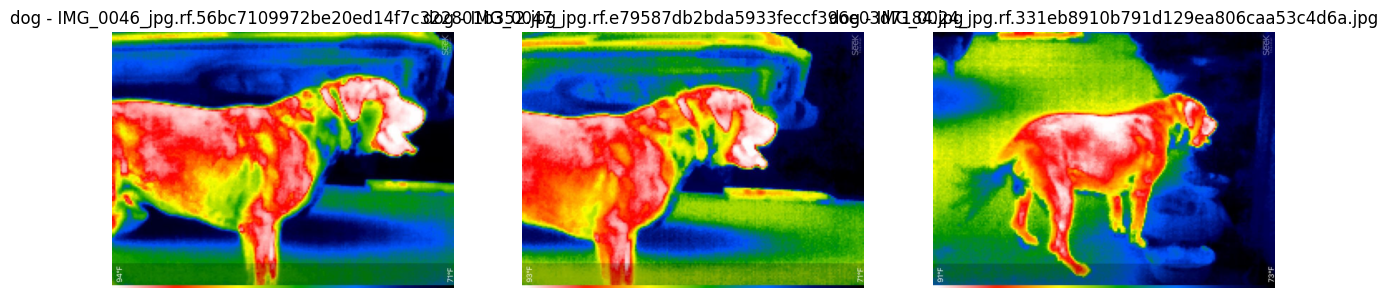

  person: ['IMG_0025-2_jpg.rf.724855152cff07b81102d0ec49e86aaa.jpg', 'IMG_0007-3_jpg.rf.a52a74aa0ec4cd3f7e49741be765bac8.jpg', 'IMG_0027-2_jpg.rf.5bb422b18401bebb1be2b8b46c5111fb.jpg']


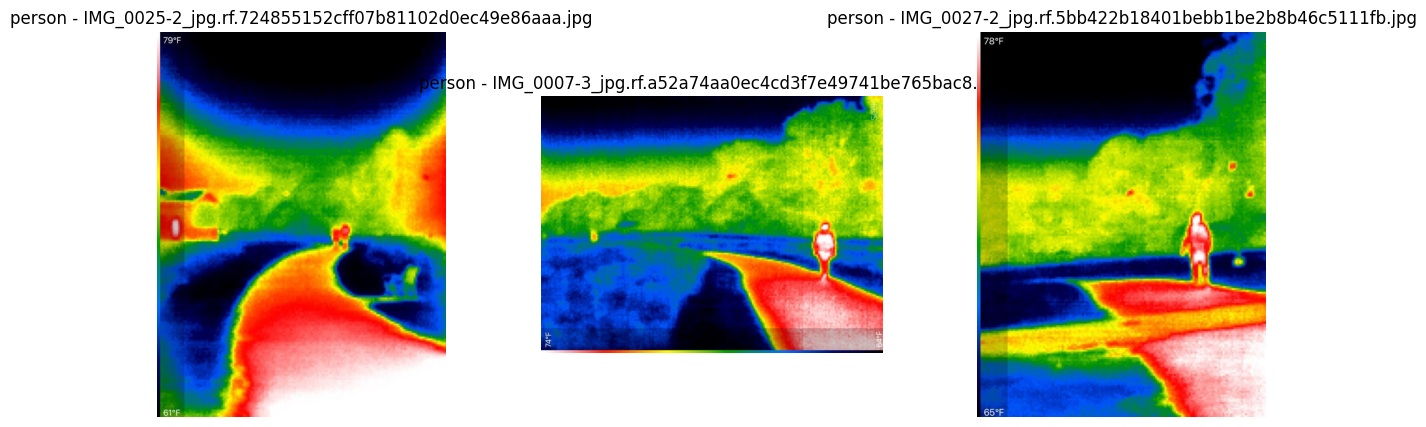

  mixed: ['IMG_0102_jpg.rf.af08e45d9564c84a4a2f3ae4539634e8.jpg', 'IMG_0103_jpg.rf.2403597d854cb88e500c928364c3cbd4.jpg', 'IMG_0072_jpg.rf.df0c3eb797a820d172378f9bbc4a8dcc.jpg']


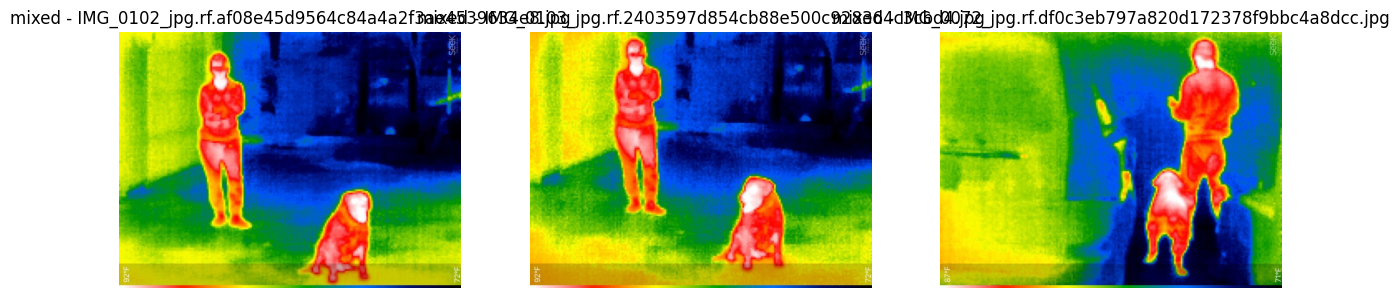


VALID SET SAMPLES:
  dog: ['IMG_0014_jpg.rf.38789b8d9e85d09facf10ce33effe5f7.jpg', 'IMG_0006_jpg.rf.696bf26255849df25e6cab8771514442.jpg', 'IMG_0086_jpg.rf.872fae12816567049f5fdd63764959fe.jpg']


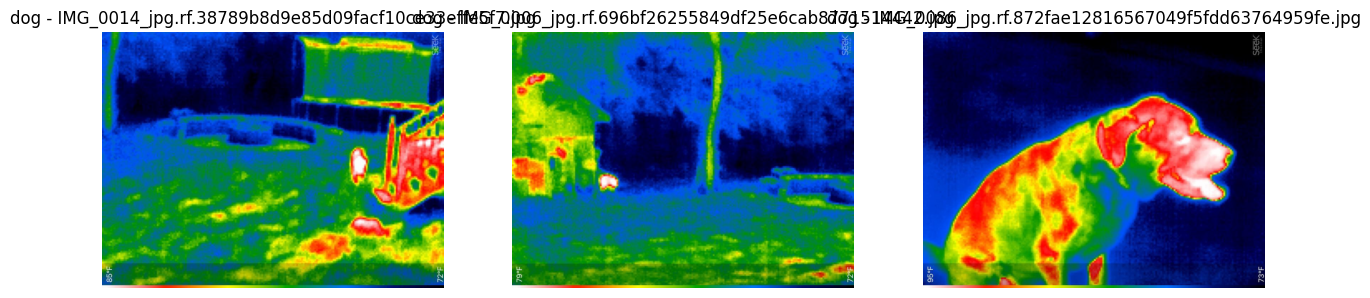

  person: ['IMG_0092_jpg.rf.ca94620a37eb3d5453e0cf3fb43ff5b1.jpg', 'IMG_0111_jpg.rf.594e1af2c3c630f8bd37e3193c7d035c.jpg', 'IMG_0052-2_jpg.rf.54a1145e8da22349c19298952fa2cd21.jpg']


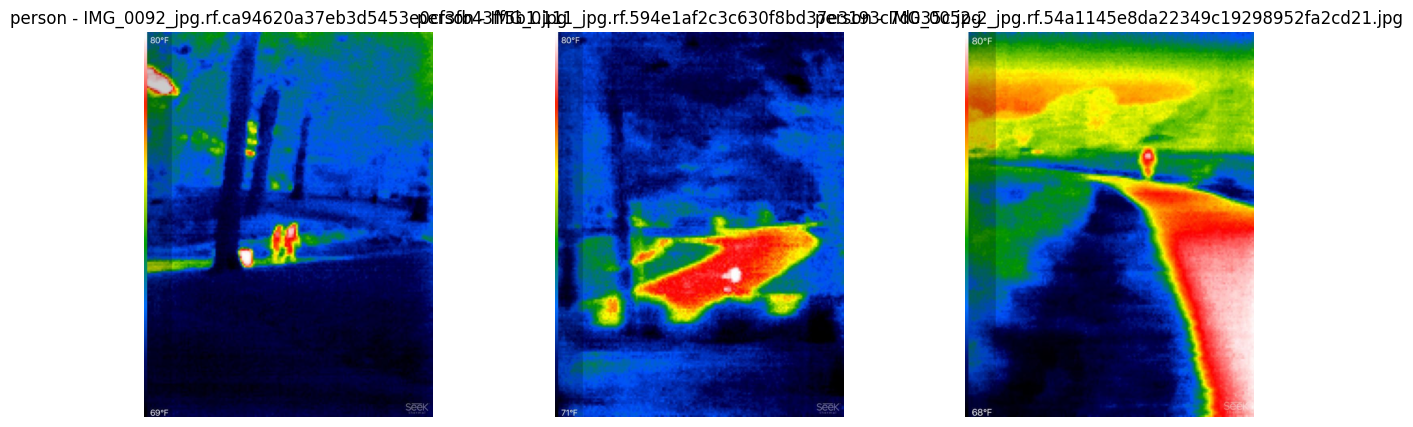

  mixed: ['IMG_0100_jpg.rf.b60b37f72bba9f57303d97fcc7420fb6.jpg', 'IMG_0075_jpg.rf.ebe283d9562c6cb3344575b614702ea8.jpg', 'IMG_0099_jpg.rf.3a2f63e3614aa606bf1a43120f8d3c2c.jpg']


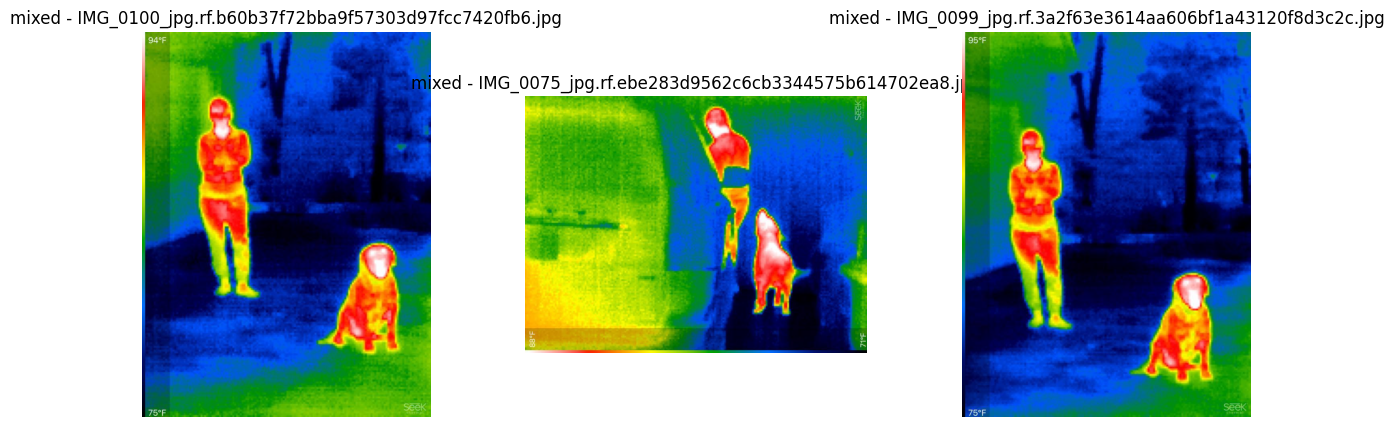


TEST SET SAMPLES:
  dog: ['IMG_0027_jpg.rf.1d755a5883c8a59ab4e0c9365f8d2cbd.jpg', 'IMG_0040-2_jpg.rf.fd02f6a30556c094f8d19531ee11ffef.jpg', 'IMG_0009_jpg.rf.4843a778e5ad0a37dc9d9eca705b8234.jpg']


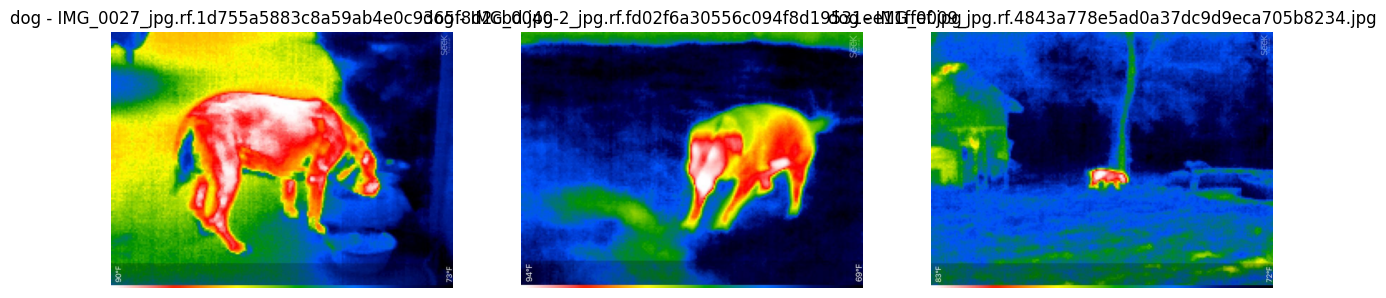

  person: ['IMG_0043-2_jpg.rf.e101b7d3f607719f72dc823b43093da1.jpg', 'IMG_0031-2_jpg.rf.b2c3bde3147f85f775040a824397f745.jpg', 'IMG_0012-2_jpg.rf.33bd9fde4442b41043fe4a8c58c495f7.jpg']


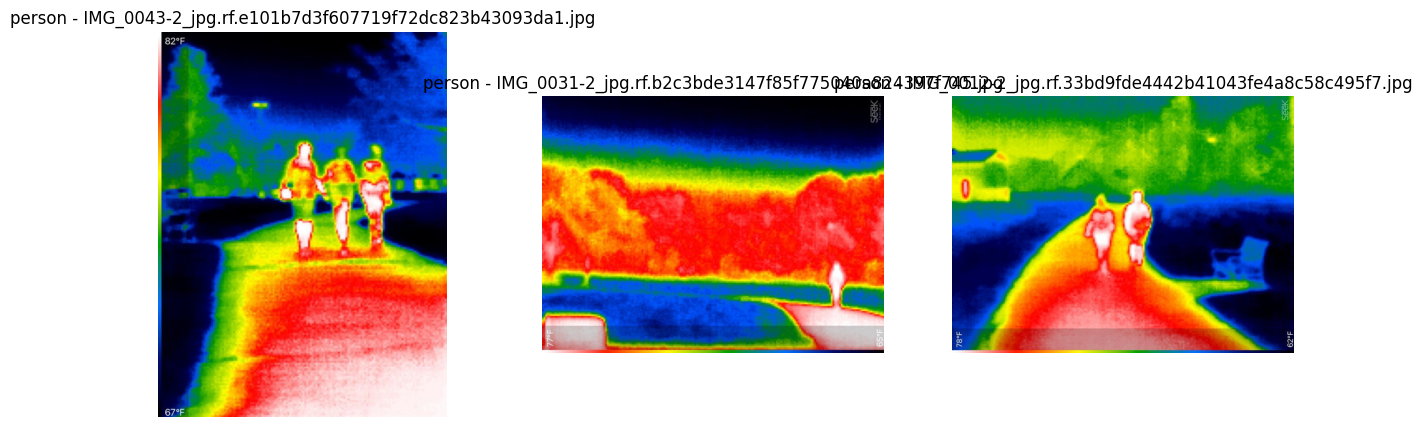

  mixed: ['IMG_0006-5_jpg.rf.7d2020803a12483f643fef278375b1aa.jpg', 'IMG_0060_jpg.rf.5bd7a3f676402b9eac6009531b07e493.jpg', 'IMG_0059_jpg.rf.f87f4d8727811e61871b785197c8d275.jpg']


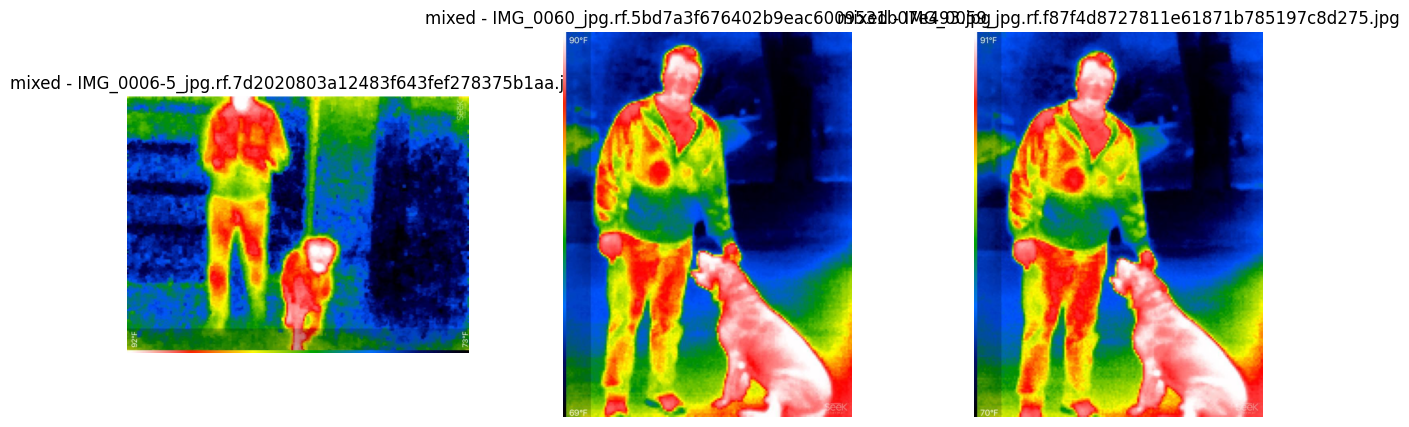

In [ ]:

import random
import matplotlib.pyplot as plt
from PIL import Image

def display_sample_images(base_dir, num_samples=3):
    for phase in ['train', 'valid', 'test']:
        phase_dir = os.path.join(base_dir, phase)
        print(f"\n{phase.upper()} SET SAMPLES:")
        for class_name in ['dog', 'person', 'mixed']:
            class_dir = os.path.join(phase_dir, class_name)
            all_images = os.listdir(class_dir)
            sample_images = random.sample(all_images, min(len(all_images), num_samples))
            print(f"  {class_name}: {sample_images}")

            # Display the images
            fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
            for idx, img_name in enumerate(sample_images):
                img_path = os.path.join(class_dir, img_name)
                image = Image.open(img_path)
                axes[idx].imshow(image)
                axes[idx].axis('off')
                axes[idx].set_title(f"{class_name} - {img_name}")
            plt.show()

# Display sample images from each class
display_sample_images(imagefolder_dir, num_samples=3)


Sets up data augmentation for the training set to improve model robustness. Validation and test sets use basic transformations for evaluation.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Data Preparation (without data augmentation)
data_dir = '/content/ThermalDogsAndPeople_ImageFolder'




# Data augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define transformations for validation and test sets (no data augmentation)
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Initializes a ResNet-18 model, adjusts the final layer for three classes, and sets up the optimizer and loss function.

In [ ]:
# Reload datasets with new transformations
train_dataset = ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = ImageFolder(root=os.path.join(data_dir, 'valid'), transform=basic_transform)
test_dataset = ImageFolder(root=os.path.join(data_dir, 'test'), transform=basic_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


weights = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float)  # Trying uniform weights
# Alternatively, reduce the magnitude of class weights
criterion = nn.CrossEntropyLoss(weight=weights.to(device))


# Model and Optimizer Setup
model = models.resnet18(weights=None) # equivalent to pretrained=false
model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust for three classes
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping and Learning Rate Scheduling Setup
early_stopping_patience = 7
best_val_loss = float('inf')
patience_counter = 0
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

Implements early stopping and learning rate reduction for training stability and to prevent overfitting.

In [ ]:
# Training Loop with Early Stopping
def train_model_with_early_stopping(model, criterion, optimizer, scheduler, num_epochs=25):
    global best_val_loss, patience_counter
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track training loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = correct_preds.double() / total_samples
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels.data)
                val_total_samples += inputs.size(0)

        val_epoch_loss = val_running_loss / val_total_samples
        val_epoch_acc = val_correct_preds.double() / val_total_samples
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.item())

        # Scheduler step
        scheduler.step(val_epoch_loss)

        # Early Stopping Check
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [ ]:
# Train the model with early stopping
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model_with_early_stopping(
    model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25: Train Loss: 1.3074, Train Acc: 0.4351, Val Loss: 1.5761, Val Acc: 0.3056
Epoch 2/25: Train Loss: 0.8844, Train Acc: 0.6641, Val Loss: 2.8931, Val Acc: 0.4444
Epoch 3/25: Train Loss: 0.5721, Train Acc: 0.7328, Val Loss: 4.6160, Val Acc: 0.4722
Epoch 4/25: Train Loss: 0.4922, Train Acc: 0.7786, Val Loss: 1.2656, Val Acc: 0.6944
Epoch 5/25: Train Loss: 0.4967, Train Acc: 0.8015, Val Loss: 1.5041, Val Acc: 0.6667
Epoch 6/25: Train Loss: 0.2642, Train Acc: 0.8855, Val Loss: 0.6192, Val Acc: 0.8056
Epoch 7/25: Train Loss: 0.3520, Train Acc: 0.8702, Val Loss: 1.1774, Val Acc: 0.6389
Epoch 8/25: Train Loss: 0.4452, Train Acc: 0.8397, Val Loss: 2.4904, Val Acc: 0.5000
Epoch 9/25: Train Loss: 0.4644, Train Acc: 0.8550, Val Loss: 0.3125, Val Acc: 0.8611
Epoch 10/25: Train Loss: 0.3214, Train Acc: 0.9008, Val Loss: 0.3451, Val Acc: 0.8611
Epoch 11/25: Train Loss: 0.2444, Train Acc: 0.9084, Val Loss: 0.4214, Val Acc: 0.8333
Epoch 12/25: Train Loss: 0.2187, Train Acc: 0.9389, Val Loss: 0

Plots loss and accuracy curves to visualize the model's learning progress across epochs.

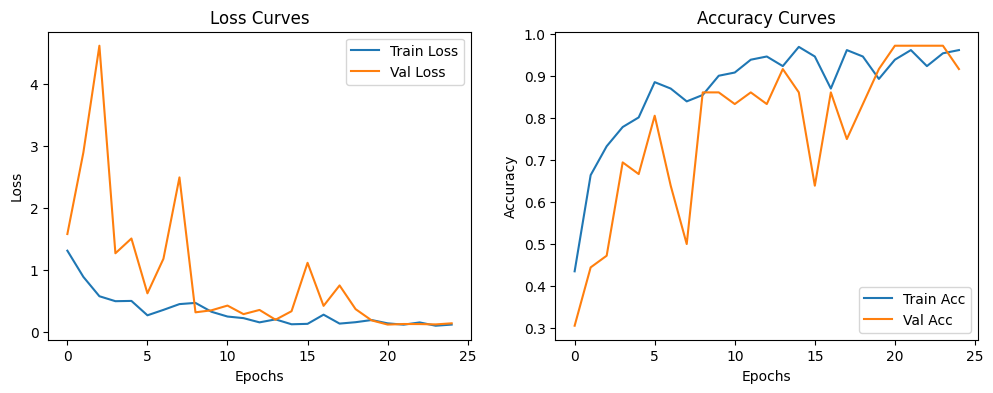

In [ ]:
# Step 5: Plot Training/Validation Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Calculates the model's test accuracy and loss, which measure its generalization to new data.

In [ ]:
def evaluate_model_on_test_set(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_preds = 0
    test_total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track the test loss and accuracy
            test_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct_preds += torch.sum(preds == labels.data)
            test_total_samples += inputs.size(0)

    # Calculate average test loss and accuracy
    test_loss = test_running_loss / test_total_samples
    test_accuracy = test_correct_preds.double() / test_total_samples

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model_on_test_set(model, test_loader, criterion)


Test Loss: 0.2500, Test Accuracy: 0.8889


Identifies and visualizes misclassified samples to understand common mistakes and potential improvements.

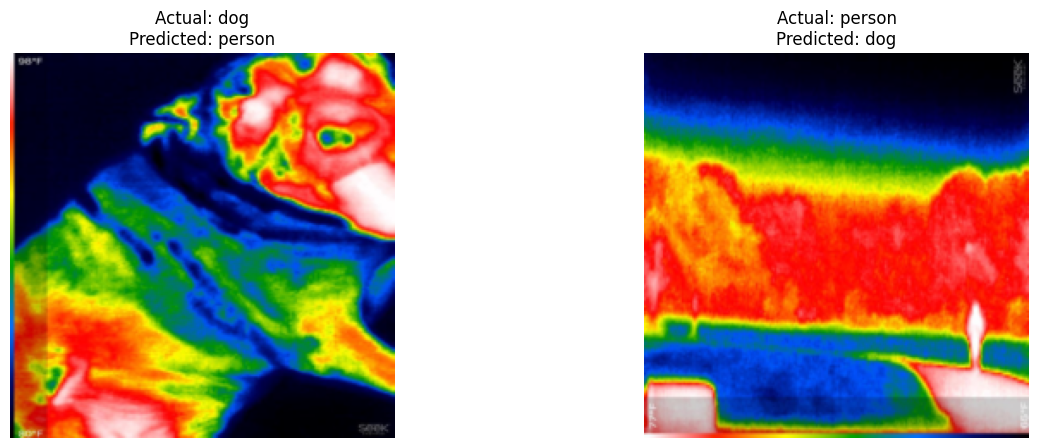

Number of misclassified samples: 2


In [ ]:
import matplotlib.pyplot as plt

def find_misclassified_samples(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Find misclassified samples
            misclassified_mask = (preds != labels)
            misclassified_images.extend(inputs[misclassified_mask].cpu())
            misclassified_labels.extend(labels[misclassified_mask].cpu())
            misclassified_preds.extend(preds[misclassified_mask].cpu())

    return misclassified_images, misclassified_labels, misclassified_preds

def display_misclassified_samples(misclassified_images, misclassified_labels, misclassified_preds, class_names, num_samples=5):
    # Display a few misclassified samples
    num_samples = min(num_samples, len(misclassified_images))
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image = misclassified_images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        image = image * 0.5 + 0.5  # Unnormalize the image
        actual_label = class_names[misclassified_labels[i]]
        predicted_label = class_names[misclassified_preds[i]]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')
    plt.show()

# Class names for the dataset
class_names = train_dataset.classes  # ['dog', 'person', 'mixed']

# Find misclassified samples
misclassified_images, misclassified_labels, misclassified_preds = find_misclassified_samples(model, test_loader)

# Display a few misclassified samples
display_misclassified_samples(misclassified_images, misclassified_labels, misclassified_preds, class_names, num_samples=5)

print(f"Number of misclassified samples: {len(misclassified_images)}")


Shows a sample of correctly classified images for each class, helping verify model performance visually across categories

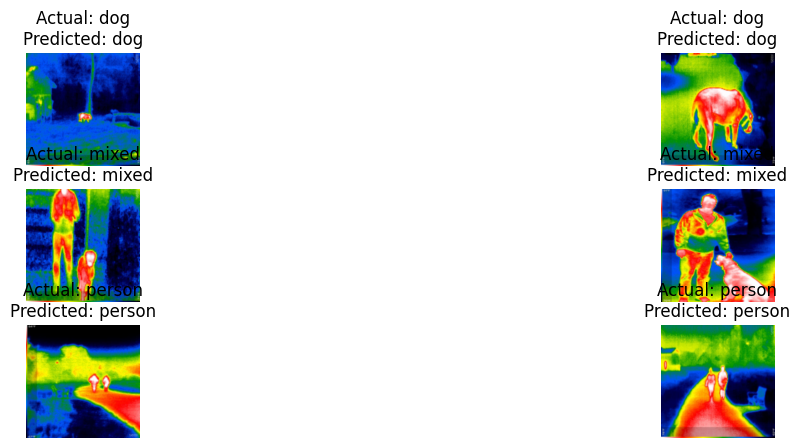

Number of correctly classified samples: 16


In [ ]:
import torch
import matplotlib.pyplot as plt

def get_correctly_classified_samples(model, dataloader, class_names):
    model.eval()
    correctly_classified_images = []
    correctly_classified_labels = []
    correctly_classified_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Identify correctly classified samples
            for i in range(inputs.size(0)):
                if preds[i] == labels[i]:
                    correctly_classified_images.append(inputs[i].cpu())
                    correctly_classified_labels.append(labels[i].cpu().item())
                    correctly_classified_preds.append(preds[i].cpu().item())

    return correctly_classified_images, correctly_classified_labels, correctly_classified_preds

def display_correctly_classified_samples_per_class(correctly_classified_images, correctly_classified_labels, correctly_classified_preds, class_names, num_samples_per_class=2):

    # Creates a dictionary to store samples for each class
    samples_per_class = {class_name: [] for class_name in class_names}

    # Collect samples per class
    for img, label, pred in zip(correctly_classified_images, correctly_classified_labels, correctly_classified_preds):
        actual_label_name = class_names[label]
        if len(samples_per_class[actual_label_name]) < num_samples_per_class:
            samples_per_class[actual_label_name].append((img, label, pred))

    # Plot the samples
    plt.figure(figsize=(15, 5))
    for class_index, (class_name, samples) in enumerate(samples_per_class.items()):
        for i, (img, label, pred) in enumerate(samples):
            img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
            img = img * 0.5 + 0.5  # Unnormalize the image (assuming normalization mean=0.5, std=0.5)
            actual_label = class_names[label]
            predicted_label = class_names[pred]
            plt.subplot(len(class_names), num_samples_per_class, class_index * num_samples_per_class + i + 1)
            plt.imshow(img)
            plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming 'test_loader' is defined, and 'class_names' is a list of class names
correctly_classified_images, correctly_classified_labels, correctly_classified_preds = get_correctly_classified_samples(
    model, test_loader, class_names
)

# Now call the function to display correctly classified samples
display_correctly_classified_samples_per_class(
    correctly_classified_images, correctly_classified_labels, correctly_classified_preds, class_names, num_samples_per_class=2
)

print(f"Number of correctly classified samples: {len(correctly_classified_images)}")